In [52]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import vrnngan2
vrnngan2 = reload(vrnngan2)
from vrnngan2 import VRNNGRUGAN, VRNNGRU
from tensorflow import keras
import tensorflow as tf


In [3]:
transactions = pd.read_csv('https://raw.githubusercontent.com/BigTuna08/Banksformer_ecml_2022/main/czech/banksformer/data/tr_by_acct_w_age.csv')

In [4]:
transactions.head()
# from 1995-03-24 to 1998-12-31

,Unnamed: 0,account_id,date,type,operation,amount,balance,k_symbol,client_id,age,datetime
0,149432,1,950324,CREDIT,CREDIT IN CASH,1000.0,1000.0,NaN,1,29,1995-03-24
1,157404,1,950413,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,4679.0,NaN,1,29,1995-04-13
2,158832,1,950423,CREDIT,CREDIT IN CASH,12600.0,17279.0,NaN,1,29,1995-04-23
3,162681,1,950430,CREDIT,NaN,19.2,17298.2,INTEREST CREDITED,1,29,1995-04-30
4,167083,1,950513,CREDIT,COLLECTION FROM ANOTHER BANK,3679.0,20977.2,NaN,1,29,1995-05-13


In [5]:
print(transactions.shape)

(1056320, 11)


d:\coding\vae-gan-privacy\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='datetime', ylabel='amount'>

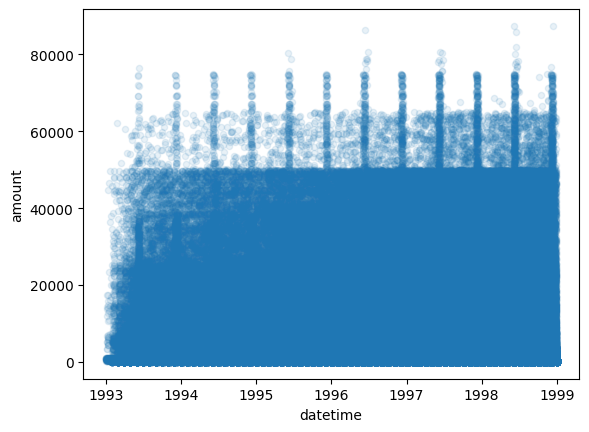

In [36]:
transactions['datetime'] = pd.to_datetime(transactions['datetime'])
# latest_date = transactions['datetime'].min()
# transactions['datetime_num'] = transactions['datetime'].apply(lambda x: (x - latest_date).days)
# transactions.plot.scatter(x='datetime_num', y='amount', alpha=0.1)
transactions.plot.scatter(x='datetime', y='amount', alpha=0.1)

<Axes: xlabel='datetime', ylabel='amount'>

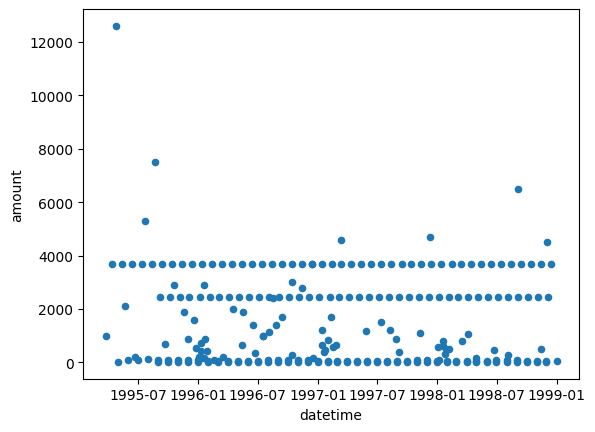

In [37]:
filtered_transactions = transactions[transactions['account_id'] == 1]
filtered_transactions.plot.scatter(x='datetime', y='amount')


In [40]:
train = np.asarray(filtered_transactions[filtered_transactions['datetime'] < '1996-07-01']['amount'])
test = np.asarray(filtered_transactions[filtered_transactions['datetime'] >= '1996-07-01']['amount'])

In [42]:
# import numpy as np
# X_train = np.asarray(filtered_transactions[(filtered_transactions['datetime_num'] > 800) & (filtered_transactions['datetime_num'] < 1400)]['datetime_num'].values.reshape(-1, 1))
# y_train = np.asarray(filtered_transactions[(filtered_transactions['datetime_num'] > 800) & (filtered_transactions['datetime_num'] < 1400)]['amount'].values.reshape(-1, 1))

# X_test = np.asarray(filtered_transactions[filtered_transactions['datetime_num'] >= 1400]['datetime_num'].values.reshape(-1, 1))
# y_test = np.asarray(filtered_transactions[filtered_transactions['datetime_num'] >= 1400]['amount'].values.reshape(-1, 1))


# window = 200
# X_train = np.asarray([train[i:i+window] for i in range(len(train)-window - 1)]).reshape(-1, window, 1)
# Y_train = np.asarray([train[i:i+window] for i in range(1, len(train)-window)]).reshape(-1, window, 1)
# X_test = np.asarray([test[i:i+window] for i in range(len(test)-window-1)]).reshape(-1, window, 1)
# Y_test = np.asarray([test[i:i+window] for i in range(1, len(test)-window)]).reshape(-1, window, 1)

window=20
X_train = np.asarray([train[i:i+window] for i in range(len(train)-window - 1)])[:,:,np.newaxis]
Y_train = np.asarray([train[i:i+window] for i in range(1, len(train)-window)])[:,:,np.newaxis]
X_test = np.asarray([test[i:i+window] for i in range(len(test)-window-1)])[:,:,np.newaxis]
Y_test = np.asarray([test[i:i+window] for i in range(len(test)-window)])[:,:,np.newaxis]

X_train.shape

(57, 20, 1)

In [54]:
tf.keras.backend.clear_session()

timesteps = X_train.shape[1]
feature_space = X_train.shape[2]
latent_dim = 16
z_dim = 16

model = VRNNGRUGAN(feature_space, z_dim, latent_dim, timesteps, 0.4)
model.compile(keras.optimizers.Adam(learning_rate=0.0001), keras.optimizers.Adam(learning_rate=0.03))
model.fit(X_train, Y_train, batch_size= 16, epochs=100)

Epoch 1/100
4/4 [==============================] - 24s 14ms/step - total_loss: 105827328.0000 - loss: 106576992.0000 - kl: 0.0285 - discrim_loss: 1.9729 - discrim_loss_fake: 0.5121 - discrim_loss_real: 0.9572
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - total_loss: 104061880.0000 - loss: 103090932.8000 - kl: 0.0258 - discrim_loss: 1.9497 - discrim_loss_fake: 0.4756 - discrim_loss_real: 0.9958
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - total_loss: 113870752.0000 - loss: 99597046.4000 - kl: 0.0235 - discrim_loss: 1.9462 - discrim_loss_fake: 0.4950 - discrim_loss_real: 0.9582
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - total_loss: 105814576.0000 - loss: 106680966.4000 - kl: 0.0239 - discrim_loss: 1.9465 - discrim_loss_fake: 0.4281 - discrim_loss_real: 1.0910
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - total_loss: 105401160.0000 - loss: 104662368.0000 - kl: 0.0226 - discrim_loss: 1.9438 - discrim_loss_f

2/2 [==============================] - 0s 5ms/step


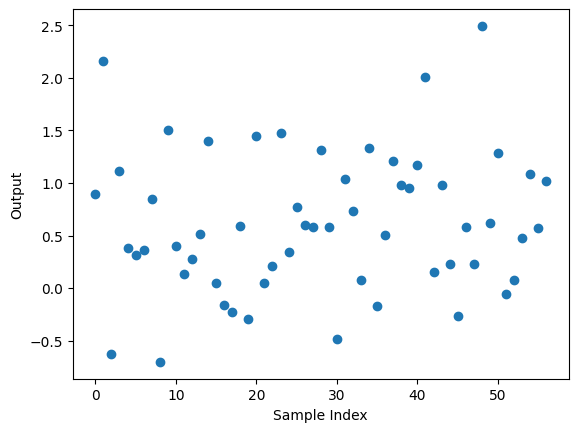

In [61]:
outputs, z, q_mu, p_mu, q_logvar, p_logvar, output_mean, output_logvar, states = model.predict(X_train[0:300])
plt.scatter(range(len(outputs)), outputs[:, -1, :])
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.show()


In [55]:
outputs, z, q_mu, p_mu, q_logvar, p_logvar, output_mean, output_logvar,_ = model.predict(X_test)

5/5 [==============================] - 0s 3ms/step


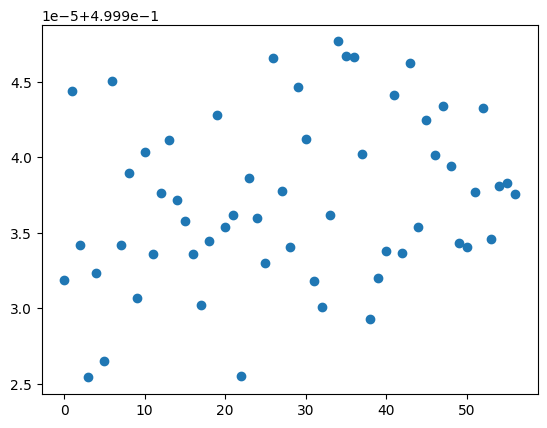

In [62]:
plt.scatter(range(len(output_mean[:,-1,:])), output_mean[:,-1,:], label='predicted')
